In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import os
import re
import gc
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# #!/bin/bash
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null

# # install spark (change the version number if needed)
# # if [[ ! -f 'spark-3.0.0-bin-hadoop3.2.tgz' ]];
# # then
# #     wget https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
# # else
# #     echo "file spark-3.0.0-bin-hadoop3.2.tgz already exists!"
# # fi

# # chmod -R 777 /content/drive/MyDrive/spark-3.0.0-bin-hadoop3.2
# # !wget https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# # unzip the spark file to the current folder
# !tar xf /content/drive/MyDrive/spark-3.0.0-bin-hadoop3.2.tgz

# !pip install -q findspark
# !pip install -q pyspark

In [4]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# import findspark
# findspark.init()
# import pyspark
# from pyspark.sql import SparkSession
# from pyspark.sql import functions as F
# from pyspark.sql.window import Window as W
# from pyspark.sql.types import BooleanType
# spark = (SparkSession.builder\
#         #  .master('local')\
#         #  .appName('Colab')\
#         #  .config('spark.ui.port', '4050')\
#          .getOrCreate()
#          )
# spark

In [5]:
# tg = spark.read.parquet('/content/drive/MyDrive/Диссертация/Парсеры сайтов/tg.parquet')

In [6]:
# news = pd.read_parquet('/content/drive/MyDrive/Диссертация/Парсеры сайтов/news.parquet')
tg = pd.read_parquet('/content/drive/MyDrive/Диссертация/Парсеры сайтов/tg.parquet')
tg_raw = pd.read_parquet('/content/drive/MyDrive/Диссертация/Парсеры сайтов/tg_raw.parquet')
tg.drop(columns=[x for x in tg.columns if bool(re.search('_close', x))], inplace=True)
tg = tg.iloc[:, :2].copy()
tg = tg.merge(tg_raw, how='left', on='date')
del tg_raw
tg.dropna(subset=['message_x', 'message_y', 'date'], inplace=True)

In [7]:
# def to_bool(df):
#   for col in df.columns:
#     if df[col].contains('True'):
#       df.withColumn(col, df.age.cast(BooleanType()))
#   return df

In [8]:
# news = to_bool(news)
# tg = to_bool(tg)

In [9]:
sectors = ['finance', 'gold', 'ferrous_metallurgy', 'oil_gas', 'non_ferrous_metallurgy', 'electrical networks', 'telecom', 'it', 'real_estate']
companies = ['ALRS', 'AFLT', 'VTBR', 'GAZP', 'GMKN', 'LSRG', 'DSKY', 'IRAO', 'LKOH', 'MAGN', 'MOEX', 'CBOM', 'MTSS', 'ROSN', 'NLMK', 'NVTK', 'PIKK', 'PLZL',
              'RTKM', 'RUAL', 'HYDR', 'SBER', 'CHMF', 'AFKS', 'SNGS', 'TATN', 'TCSG', 'TRNFP', 'POGR', 'PHOR', 'FEES', 'HHRU', 'YNDX']

In [10]:
tg = tg.drop(columns=['views', 'forwards', 'fwd_from'])
tg = tg[tg.date < '2022-01-01'].copy()
tg = tg.drop(columns=sectors)
tg.rename(columns={'message_x': 'message_prep', 'message_y': 'message_raw'}, inplace=True)

In [11]:
# print((tg.count(), len(tg.columns)))

In [12]:
# tg.drop(columns=['views', 'forwards', 'fwd_from'], inplace=True)
# # tg.dropna(inplace=True)
# tg.sort_values('date', inplace=True)
# tg = tg[tg['date'] < '2022-01-01']
# tg.reset_index(drop=True, inplace=True)
# # news.drop(columns=['title', 'announce'], inplace=True)

In [13]:
# def get_time_lags(df, mins, hours, days, com):
#     price = pd.read_csv(f'/content/drive/MyDrive/Диссертация/Парсеры сайтов/Стоимость акций/1 мин/{com}.csv')
#     price['timestamp'] = pd.to_datetime(price['timestamp'])
#     price.rename(columns={'timestamp':'date'}, inplace=True)
#     price.sort_values('date', ignore_index=True, inplace=True)
    
#     tmp_mins = pd.DataFrame()
#     for m in mins:
#         delta = pd.Timedelta(m, unit='min')
#         df['date'] -= delta
#         mins_price = pd.merge_asof(df, price, on='date', direction='backward')['close']
#         df['date'] += delta
#         tmp_mins = pd.concat([tmp_mins, mins_price], axis=1)
        
#     tmp_mins = tmp_mins.to_numpy()
    
#     tmp_hours = pd.DataFrame()
#     for h in hours:
#         m = 60 * h
#         delta = pd.Timedelta(m, unit='min')
#         df['date'] -= delta
#         hours_price = pd.merge_asof(df, price, on='date', direction='backward')['close']
#         df['date'] += delta
#         tmp_hours = pd.concat([tmp_hours, hours_price], axis=1)
        
#     tmp_hours = tmp_hours.to_numpy()
    
#     tmp_days = pd.DataFrame()
#     for d in days:
#         m = 24 * 60 * d
#         delta = pd.Timedelta(m, unit='min')
#         df['date'] -= delta
#         days_price = pd.merge_asof(df, price, on='date', direction='backward')['close']
#         df['date'] += delta
#         tmp_days = pd.concat([tmp_days, days_price], axis=1)
    
#     tmp_days.dropna(inplace=True)
    
#     return tmp_mins, tmp_hours, tmp_days

In [14]:
# gazp = tg[tg['GAZP'] == True].copy()
# mins, _, _ = get_time_lags(gazp, [0], [], [], 'GAZP')
# gazp['now'] = mins
# columns = ['date', 'message', 'now'] + [col for col in gazp.columns if 'GAZP' in col]
# gazp = gazp[columns]
# gazp.drop(columns=['GAZP'], inplace=True)

In [ ]:
# Случайный лес
targets = tg.iloc[3:,:-1].columns
for company in companies:
  print(company)
  # os.mkdir(f'/content/drive/MyDrive/Диссертация/{company}')
  comp = tg[tg[company] == True].copy()
  comp.dropna(inplace=True)
  train, test = comp.iloc[:int(0.8*len(comp)), :], comp.iloc[int(0.8*len(comp)):, :]
  tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1,2))
  features_train = tfidf.fit_transform(train['message_prep'])
  features_test = tfidf.transform(test['message_prep'])
  X_train = features_train.todense()
  X_test = features_test.todense()
  tr = [col for col in targets if company in col]
  train_logg = []
  test_logg = []
  base_acc = []
  for t in tr:
    y_train = train[t].values.astype(int)
    y_test = test[t].values.astype(int)
    base_acc.append(np.mean(y_train))
    for depth in range(3, 16):
      clf = RandomForestClassifier(random_state=123, criterion='entropy', n_jobs=-1, max_depth=depth)
      y_pred = clf.fit(np.asarray(X_train), y_train).predict(np.asarray(X_test))
      test_logg.append(np.mean(y_test==y_pred))
      train_pred = clf.predict(np.asarray(X_train))
      train_logg.append(np.mean(y_train==train_pred))

  with open(f'/content/drive/MyDrive/Диссертация/{company}/{company}_train_logg2.txt', 'w') as fp:
    for item in train_logg:
        fp.write("%s\n" % item)
  with open(f'/content/drive/MyDrive/Диссертация/{company}/{company}_test_logg2.txt', 'w') as fp:
    for item in test_logg:
        fp.write("%s\n" % item)

  with open(f'/content/drive/MyDrive/Диссертация/{company}/{company}_base_acc_logg2.txt', 'w') as fp:
    for item in base_acc:
        fp.write("%s\n" % item)

  
  print(f'{company} done')

ALRS
ALRS done
AFLT
AFLT done
VTBR
VTBR done
GAZP
GAZP done
GMKN
GMKN done
LSRG
LSRG done
DSKY
DSKY done
IRAO
IRAO done
LKOH
LKOH done
MAGN
MAGN done
MOEX
MOEX done
CBOM
CBOM done
MTSS
MTSS done
ROSN
ROSN done
NLMK
NLMK done
NVTK
NVTK done
PIKK
PIKK done
PLZL
PLZL done
RTKM
RTKM done
RUAL
RUAL done
HYDR
HYDR done
SBER
SBER done
CHMF
CHMF done
AFKS
AFKS done
SNGS
SNGS done
TATN
TATN done
TCSG
TCSG done
TRNFP
TRNFP done
POGR
POGR done
PHOR
PHOR done
FEES
FEES done
HHRU
HHRU done
YNDX
YNDX done


In [ ]:
#Градиентный бустинг
targets = tg.iloc[3:,:-1].columns
for company in companies:
  print(company)
  # os.mkdir(f'/content/drive/MyDrive/Диссертация/{company}')
  comp = tg[tg[company] == True].copy()
  comp.dropna(inplace=True)
  train, test = comp.iloc[:int(0.8*len(comp)), :], comp.iloc[int(0.8*len(comp)):, :]
  tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1,2))
  features_train = tfidf.fit_transform(train['message_prep'])
  features_test = tfidf.transform(test['message_prep'])
  X_train = features_train.todense()
  X_test = features_test.todense()
  tr = [col for col in targets if company in col]
  train_logg = []
  test_logg = []
  base_acc = []
  for t in tr:
    y_train = train[t].values.astype(int)
    y_test = test[t].values.astype(int)
    base_acc.append(np.mean(y_train))
    for depth in range(3, 16):
      clf = LGBMClassifier(random_state=123, n_jobs=-1, max_depth=depth)
      y_pred = clf.fit(np.asarray(X_train), y_train).predict(np.asarray(X_test))
      test_logg.append(np.mean(y_test==y_pred))
      train_pred = clf.predict(np.asarray(X_train))
      train_logg.append(np.mean(y_train==train_pred))

  with open(f'/content/drive/MyDrive/Диссертация/{company}/{company}_train_logg_boosting2.txt', 'w') as fp:
    for item in train_logg:
        fp.write("%s\n" % item)
  with open(f'/content/drive/MyDrive/Диссертация/{company}/{company}_test_logg_boosting2.txt', 'w') as fp:
    for item in test_logg:
        fp.write("%s\n" % item)

  with open(f'/content/drive/MyDrive/Диссертация/{company}/{company}_base_acc_logg_boosting2.txt', 'w') as fp:
    for item in base_acc:
        fp.write("%s\n" % item)

  
  print(f'{company} done')

ALRS
ALRS done
AFLT
AFLT done
VTBR
VTBR done
GAZP
GAZP done
GMKN
GMKN done
LSRG
LSRG done
DSKY
DSKY done
IRAO
IRAO done
LKOH
LKOH done
MAGN
MAGN done
MOEX
MOEX done
CBOM
CBOM done
MTSS
MTSS done
ROSN
ROSN done
NLMK
NLMK done
NVTK
NVTK done
PIKK
PIKK done
PLZL
PLZL done
RTKM
RTKM done
RUAL
RUAL done
HYDR
HYDR done
SBER
SBER done
CHMF
CHMF done
AFKS
AFKS done
SNGS
SNGS done
TATN
TATN done
TCSG
TCSG done
TRNFP
TRNFP done
POGR
POGR done
PHOR
PHOR done
FEES
FEES done
HHRU
HHRU done
YNDX
YNDX done


### Нейросетевой подход

In [15]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.1 MB/s eta 0:00:00


In [16]:
import torch
from torch import nn
from torch.utils.data import Dataset
from transformers import BertTokenizer
from transformers import BertModel

In [17]:
tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')

In [18]:
class TgDataset(Dataset):
    def __init__(self, texts, targets):
    
      self.labels = targets.astype(int)
      self.texts = [tokenizer(text, 
                          padding='max_length', max_length = 512, truncation=True,
                          return_tensors="pt") for text in texts]

    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_y = self.labels[idx]

        return batch_texts, batch_y

In [19]:
class BertClassifier(nn.Module):

    def __init__(self, n_classes=7):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
        self.classifier = nn.Linear(768, n_classes)
        self.act = nn.Softmax(dim=1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        final = self.classifier(pooled_output)
        final = self.act(final)
        return final

In [41]:
from torch.optim import AdamW
from tqdm import tqdm

def train(model, train_texts, val_texts, train_target, val_target, learning_rate, epochs):

    train, val = TgDataset(train_texts, train_target), TgDataset(val_texts, val_target)

    mean_1_min, mean_5_min, mean_10_min, mean_15_min, mean_30_min, mean_1_hour, mean_1_day = train_target.mean(axis=0)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCELoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            acc_1_min_train = 0
            acc_5_min_train = 0
            acc_10_min_train = 0
            acc_15_min_train = 0
            acc_30_min_train = 0
            acc_1_hour_train = 0
            acc_1_day_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.float())
                total_loss_train += batch_loss.item()
                
                acc_1_min_train += ((output[:,0] > mean_1_min).int() == train_label[:,0]).sum().item()
                acc_5_min_train += ((output[:,1] > mean_5_min).int() == train_label[:,1]).sum().item()
                acc_10_min_train += ((output[:,2] > mean_10_min).int() == train_label[:,2]).sum().item()
                acc_15_min_train += ((output[:,3] > mean_15_min).int() == train_label[:,3]).sum().item()
                acc_30_min_train += ((output[:,4] > mean_30_min).int() == train_label[:,4]).sum().item()
                acc_1_hour_train += ((output[:,5] > mean_1_hour).int() == train_label[:,5]).sum().item()
                acc_1_day_train += ((output[:,6] > mean_1_day).int() == train_label[:,6]).sum().item()

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            acc_1_min_val = 0
            acc_5_min_val = 0
            acc_10_min_val = 0
            acc_15_min_val = 0
            acc_30_min_val = 0
            acc_1_hour_val = 0
            acc_1_day_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.float())
                    total_loss_val += batch_loss.item()
                    
                    acc_1_min_val += ((output[:,0] > mean_1_min).int() == val_label[:,0]).sum().item()
                    acc_5_min_val += ((output[:,1] > mean_5_min).int() == val_label[:,1]).sum().item()
                    acc_10_min_val += ((output[:,2] > mean_10_min).int() == val_label[:,2]).sum().item()
                    acc_15_min_val += ((output[:,3] > mean_15_min).int() == val_label[:,3]).sum().item()
                    acc_30_min_val += ((output[:,4] > mean_30_min).int() == val_label[:,4]).sum().item()
                    acc_1_hour_val += ((output[:,5] > mean_1_hour).int() == val_label[:,5]).sum().item()
                    acc_1_day_val += ((output[:,6] > mean_1_day).int() == val_label[:,6]).sum().item()
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train): .3f} \
                | Train Acc 1 min: {acc_1_min_train / len(train): .3f} \
                | Train Acc 5 min: {acc_5_min_train / len(train): .3f} \
                | Train Acc 10 min: {acc_10_min_train / len(train): .3f} \
                | Train Acc 15 min: {acc_15_min_train / len(train): .3f} \
                | Train Acc 30 min: {acc_30_min_train / len(train): .3f} \
                | Train Acc 1 hour: {acc_1_hour_train / len(train): .3f} \
                | Train Acc 1 day: {acc_1_day_train / len(train): .3f} \
                | Val Loss: {total_loss_val / len(val): .3f} \
                | Val Acc 1 min: {acc_1_min_val / len(val): .3f} \
                | Val Acc 5 min: {acc_5_min_val / len(val): .3f} \
                | Val Acc 10 min: {acc_10_min_val / len(val): .3f} \
                | Val Acc 15 min: {acc_15_min_val / len(val): .3f} \
                | Val Acc 30 min: {acc_30_min_val / len(val): .3f} \
                | Val Acc 1 hour: {acc_1_hour_val / len(val): .3f} \
                | Val Acc 1 day: {acc_1_day_val / len(val): .3f}')

In [21]:
EPOCHS = 3
model = BertClassifier()
LR = 1e-6

Some weights of the model checkpoint at SkolkovoInstitute/russian_toxicity_classifier were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
count = tg['message_raw'].str.split().apply(len)

In [41]:
(count == 0).sum()

17933

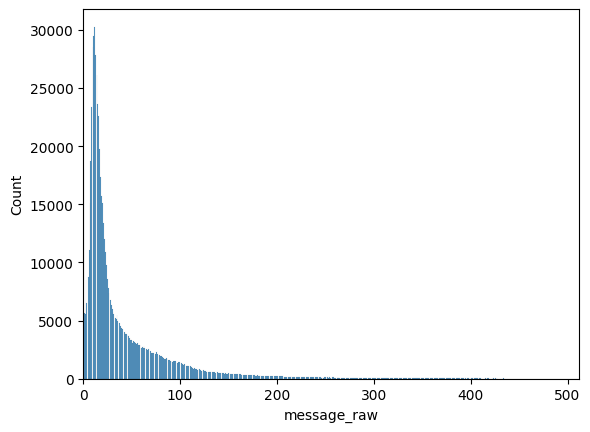

In [38]:
sns.histplot(count)
plt.xlim([0, 512]);

In [22]:
comp = tg[tg['GAZP'] == True].copy()
comp.dropna(inplace=True)
train_data, test_data = comp.iloc[:int(0.8*len(comp)), :], comp.iloc[int(0.8*len(comp)):, :]
cols = [col for col in train_data.columns if 'GAZP_' in col]

In [43]:
counts_gazp = train_data['message_raw'].str.split().apply(len)

In [49]:
counts_gazp.max()

515

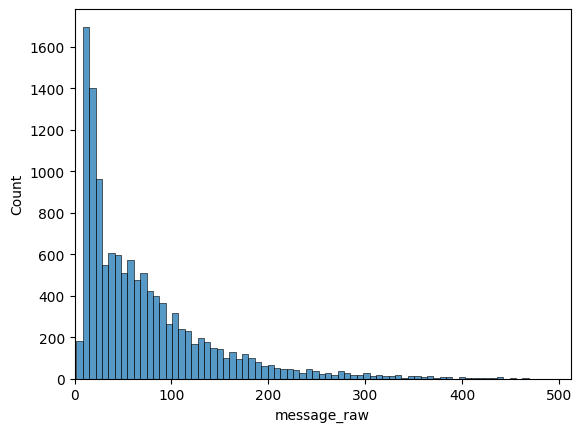

In [44]:
sns.histplot(counts_gazp)
plt.xlim([0, 512]);

In [23]:
train_texts, val_texts = train_data['message_raw'].values, test_data['message_raw'].values
train_target, val_target = train_data[cols].values, test_data[cols].values

In [26]:
train(model, train_texts, val_texts, train_target, val_target, LR, EPOCHS)

100%|██████████| 1571/1571 [19:15<00:00,  1.36it/s]


Epochs: 1 | Train Loss:  0.139                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.140                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


100%|██████████| 1571/1571 [19:20<00:00,  1.35it/s]


Epochs: 2 | Train Loss:  0.138                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.140                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


100%|██████████| 1571/1571 [19:21<00:00,  1.35it/s]


Epochs: 3 | Train Loss:  0.138                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.140                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


In [38]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Диссертация/Tg_raw_Bert_russian_toxicity_classifier.pth')

In [45]:
def evaluate(model, test_texts, test_target, train_target):

    mean_1_min, mean_5_min, mean_10_min, mean_15_min, mean_30_min, mean_1_hour, mean_1_day = train_target.mean(axis=0)
    test = TgDataset(test_texts, test_target)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    acc_1_min_test = 0
    acc_5_min_test = 0
    acc_10_min_test = 0
    acc_15_min_test = 0
    acc_30_min_test = 0
    acc_1_hour_test = 0
    acc_1_day_test = 0
    total_loss_test = 0

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc_1_min_test += ((output[:,0] > mean_1_min).int() == test_label[:,0]).sum().item()
              acc_5_min_test += ((output[:,1] > mean_5_min).int() == test_label[:,1]).sum().item()
              acc_10_min_test += ((output[:,2] > mean_10_min).int() == test_label[:,2]).sum().item()
              acc_15_min_test += ((output[:,3] > mean_15_min).int() == test_label[:,3]).sum().item()
              acc_30_min_test += ((output[:,4] > mean_30_min).int() == test_label[:,4]).sum().item()
              acc_1_hour_test += ((output[:,5] > mean_1_hour).int() == test_label[:,5]).sum().item()
              acc_1_day_test += ((output[:,6] > mean_1_day).int() == test_label[:,6]).sum().item()
            
    print(
      f'| Test Acc 1 min: {acc_1_min_test / len(test): .3f} \
      | Test Acc 5 min: {acc_5_min_test / len(test): .3f} \
      | Test Acc 10 min: {acc_10_min_test / len(test): .3f} \
      | Test Acc 15 min: {acc_15_min_test / len(test): .3f} \
      | Test Acc 30 min: {acc_30_min_test / len(test): .3f} \
      | Test Acc 1 hour: {acc_1_hour_test / len(test): .3f} \
      | Test Acc 1 day: {acc_1_day_test / len(test): .3f}')
    
evaluate(model, val_texts, val_target, train_target)

In [35]:
train_texts, val_texts = train_data['message_prep'].values, test_data['message_prep'].values
train_target, val_target = train_data[cols].values, test_data[cols].values

In [39]:
EPOCHS = 3
model = BertClassifier()
LR = 3e-4

Some weights of the model checkpoint at SkolkovoInstitute/russian_toxicity_classifier were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
train(model, train_texts, val_texts, train_target, val_target, LR, EPOCHS)

100%|██████████| 1571/1571 [19:04<00:00,  1.37it/s]


Epochs: 1 | Train Loss:  0.139                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.142                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


100%|██████████| 1571/1571 [19:08<00:00,  1.37it/s]


Epochs: 2 | Train Loss:  0.139                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.142                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


100%|██████████| 1571/1571 [19:08<00:00,  1.37it/s]


Epochs: 3 | Train Loss:  0.139                 | Train Acc 1 min:  0.000                 | Train Acc 5 min:  0.000                 | Train Acc 10 min:  0.000                 | Train Acc 15 min:  0.000                 | Train Acc 30 min:  0.000                 | Train Acc 1 hour:  0.000                 | Train Acc 1 day:  0.000                 | Val Loss:  0.141                 | Val Acc 1 min:  0.000                 | Val Acc 5 min:  0.000                 | Val Acc 10 min:  0.000                 | Val Acc 15 min:  0.000                 | Val Acc 30 min:  0.000                 | Val Acc 1 hour:  0.000                 | Val Acc 1 day:  0.000


In [43]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Диссертация/Tg_prep_Bert_russian_toxicity_classifier.pth')

In [44]:
evaluate(model, val_texts, val_target, train_target)

| Test Acc 1 min:  0.463       | Test Acc 5 min:  0.458       | Test Acc 10 min:  0.460       | Test Acc 15 min:  0.468       | Test Acc 30 min:  0.472       | Test Acc 1 hour:  0.462       | Test Acc 1 day:  0.457
